In [1]:
## import os
import torch
import time
from transformer_common import TransformerConfig, TransformerRunner, plot_timeseries
print(torch.cuda.is_available())

# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


import torch
from torch import nn as nn
from torch.nn import functional as F

from transformer_common import GeluFeedForward, TransformerConfig, \
    PositionalEmbedding, DistancePositionalEmbedding, AbstractModel, RMSNorm,LinearFeedForward
from torchtune.modules import RotaryPositionalEmbeddings


class Block(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.l_norm1 = RMSNorm(config.n_embed)
        self.attention = attention_provider()
        self.l_norm2 = RMSNorm(config.n_embed)
        self.ffwd = GeluFeedForward(config.n_embed, config.hidden_size, config.n_embed, config.dropout, bias=False)

    def forward(self, x, pos_emb, pos_dist_emb):
        x = x + self.attention(self.l_norm1(x), pos_emb, pos_dist_emb)
        x = x + self.ffwd.forward(self.l_norm2(x))
        return x

class BlockSequence(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.blocks = nn.Sequential(*[Block(config, attention_provider) for _ in range(config.n_layer)])

    def forward(self, x, pos_emb, pos_dist_emb):
        for block in self.blocks:
            x = block(x, pos_emb, pos_dist_emb)
        return x

    
class TorchMultiHeadAttention(nn.Module):
    # https: // pytorch.org / docs / stable / generated / torch.nn.functional.scaled_dot_product_attention.html
    def __init__(self, config):
        super().__init__()

        num_heads = config.n_head
        embed_dimension = config.n_embed
        is_causal = config.causal
        dropout = config.dropout
        bias = False

        assert embed_dimension % num_heads == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(embed_dimension, 3 * embed_dimension, bias=bias)
        # output projection
        self.c_proj = nn.Linear(embed_dimension, embed_dimension, bias=bias)
        # regularization
        self.dropout = dropout
        self.resid_dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.embed_dimension = embed_dimension
        # Perform causal masking
        self.is_causal = is_causal

    def forward(self, x, pos_emb, pos_dist_emb):
    
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        query_projected = self.c_attn(x + pos_emb)

        batch_size = query_projected.size(0)
        embed_dim = query_projected.size(2)
        head_dim = embed_dim // (self.num_heads * 3)

        query, key, value = query_projected.chunk(3, -1)
        query = query.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)

        # Apply attention with modified scores
        if self.training:
            dropout = self.dropout
            is_causal = self.is_causal
        else:
            dropout = 0.0
            is_causal = False

        y = F.scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=dropout,
                                           is_causal=is_causal)

        y = y.transpose(1, 2).view(batch_size, -1, self.num_heads * head_dim)

        y = self.resid_dropout(self.c_proj(y))
        return y



class TorchTransformerModel(AbstractModel):
    def __init__(self, config):
        super().__init__(config)
        self.pos_emb1 = PositionalEmbedding(config)
        self.pos_dist_emb1 = DistancePositionalEmbedding(config)
        self.ffwd1 = GeluFeedForward(config.input_embed, config.hidden_size, config.n_embed, config.dropout, bias=True)
        self.t1 = BlockSequence(config, lambda: TorchMultiHeadAttention(config))
        self.ffwd2 = GeluFeedForward(config.n_embed, config.hidden_size, config.output_embed, config.dropout, bias=True)

    def forward(self, inp):
        x = inp
        b, t, c = x.shape
        x = self.ffwd1(x)
        pos_emb = self.pos_emb1(b, t)
        pos_dist_emb = self.pos_dist_emb1(b)
        x = self.t1(x, pos_emb, pos_dist_emb)
        x = self.ffwd2(x)
        return x



True


torch.Size([1, 6000])


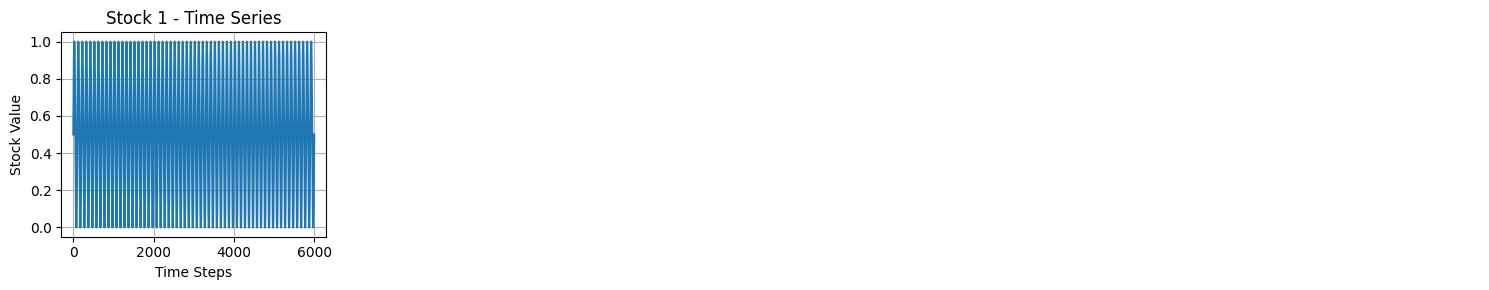

In [2]:
import torch
import math

# Parameters
n = 6000  # Number of data points
num_of_channels = 1   

# Generate a time series of n points
t = torch.linspace(0, n // 100 * 2 * math.pi, n)

# Generate sine values for the batch
sin_values = torch.sin(t).unsqueeze(1).repeat(1, num_of_channels).transpose(0,1)

sin_values = (sin_values + 1) / 2  # [0, 1]

# sin_values = torch.ones(num_of_channels, n) * 0.24

print(sin_values.shape)  # Should be [n, b]

clean_data = sin_values.transpose(0, 1)

plot_timeseries(clean_data.to(dtype=torch.float32).transpose(0,1), num_charts=1)


In [ ]:
config = TransformerConfig(
    precision=torch.float32,
    batch_size=128,
    block_size=128,
    causal=True,
    input_embed=num_of_channels,
    n_embed=16,
    output_embed=num_of_channels,
    n_head=4,
    n_layer=4,
    learning_rate=1e-4
)
config.eval_interval=50
config.save_model_periodically_every_n_iterations = -1

clean_data = clean_data.to(config.my_device)

trainer1 = TransformerRunner(config, TorchTransformerModel(config), clean_data, clean_data)

trainer1.train_iterate_n(10000)

Using device: cuda
0.020241 M parameters
step 0: rmse train loss 0.7763, rmse val loss 0.7757, sec/iter 3.924369812011719e-06
step 50: rmse train loss 0.3694, rmse val loss 0.3701, sec/iter 0.027997584342956544
step 100: rmse train loss 0.3245, rmse val loss 0.3248, sec/iter 0.02444270610809326
step 150: rmse train loss 0.2642, rmse val loss 0.2651, sec/iter 0.024340991973876954
step 200: rmse train loss 0.2320, rmse val loss 0.2326, sec/iter 0.025836129188537598
step 250: rmse train loss 0.2260, rmse val loss 0.2258, sec/iter 0.02481971263885498
step 300: rmse train loss 0.2221, rmse val loss 0.2219, sec/iter 0.023721480369567872
step 350: rmse train loss 0.2199, rmse val loss 0.2191, sec/iter 0.025309205055236816
step 400: rmse train loss 0.2173, rmse val loss 0.2179, sec/iter 0.024605302810668944
step 450: rmse train loss 0.2151, rmse val loss 0.2145, sec/iter 0.02523770332336426
step 500: rmse train loss 0.2143, rmse val loss 0.2141, sec/iter 0.026565861701965333
step 550: rmse tra

In [ ]:
context = clean_data[-config.block_size:, :].unsqueeze(0).cuda()  # Use last block_size days as context
print(f"context={context.shape}")

In [ ]:
prediction = trainer1.generate(context.to(dtype=config.precision), 500)[0,:,:].transpose(0,1).to(dtype=config.precision)

In [ ]:
plot_timeseries(prediction.to(dtype=torch.float32), num_charts=1)

In [ ]:
sh = 30
context = clean_data[-config.block_size-sh:-sh, :].unsqueeze(0).cuda()  # Use last block_size days as context
prediction = trainer1.generate(context.to(dtype=config.precision), 4)[0,:,:].transpose(0,1).to(dtype=config.precision)
plot_timeseries(prediction.to(dtype=torch.float32), num_charts=1)